# This notebook contains the algorithm for spatial clustering developed in the separate notebook
The second notebook (with analysis and development) is also provided in a separate file.

In [1]:
# importing all necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


from tqdm import tqdm_notebook

import warnings

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

pd.options.display.float_format = '{:.4f}'.format

warnings.filterwarnings('ignore')

plt.style.use('dark_background')

In [3]:
# reading in the provided data set

initial_df = pd.read_csv(r'C:\Users\79175\Desktop\BGI Group Recruiting/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv',
                delimiter = '\t')

# Restructuring the initial dataset in order for it to be used for clustering

The initial data set has to be restructured in such a way that:
   1. 'cell' is used as a unique index; 
   2. 'geneID' is used as a feature; 
   3. 'MIDCounts' is used to place the respective values inside each gene based feature.

In [4]:
# Creating a list containing all columns that will be in the final dataset
columns_for_restrucred_df = ['x', 'y']


for i in initial_df['geneID'].unique():
    columns_for_restrucred_df.append(i)

In [5]:
# Creating the restructured data set

restructured_df = pd.DataFrame(index = initial_df['cell'].unique(), columns = columns_for_restrucred_df)

In [6]:
# Fill in the values for x and y variables

for i in tqdm_notebook(restructured_df.index):
    restructured_df['x'].loc[i] = initial_df[initial_df['cell'] == i]['x'].mean()
    restructured_df['y'].loc[i] = initial_df[initial_df['cell'] == i]['y'].mean()

In [7]:
# Fill in the values for features based on cell genetic composition

for i in tqdm_notebook(restructured_df.index):
    d = initial_df[initial_df['cell'] == i][['geneID', 'MIDCounts']].T.to_dict()
    for j in d.keys():
        restructured_df[d[j]['geneID']].loc[i] = d[j]['MIDCounts']

# Data Cleaning and Principal Component Analysis (PCA) 
In order to reduce the number of features used by the final model and increase its bias PCA is introduced in this section. <br>  However, it was found during the analysis that PCA picks up too much noise from the features that are missing more than 90% of entries. Therefore, to solve the problem, these features are dropped before the PCA.

### Cleaning the data set by removing features that are missing more than 90% of entries

In [8]:
# Calculate the percentage of missing entries for each feature

empty_feat_list = restructured_df.isnull().sum().sort_values(ascending = True)/len(restructured_df)*100

In [9]:
# Creating a list containing features that are missing less than 90% of entries

list_of_features_to_use = empty_feat_list.reset_index()[empty_feat_list.reset_index()[0] < 90]['index'].tolist()

In [10]:
# Removing features that are missing more than 90% of the entries from the restructured data set

restructured_df = restructured_df[list_of_features_to_use]

### Filling in NaN values with 0s
Filling the values is required for the PCA. Moreover, this step is logical and based on an "educated guess" that NaN means that there are 0 particular genes found in that particular cell.

In [11]:
# Filling missing entries with 0s

restructured_df = restructured_df.fillna(0)

### Scaling data to prepare if for Principle Component Analysis

In [12]:
# Creating an instance of Standard Scaler

standard_scaler = StandardScaler()

In [13]:
# Scaling the data

scaled_data_for_pca = standard_scaler.fit_transform(restructured_df)

### Principle Component Analysis

Experimentation and analysis have shown that with the number of Principal Components = 100, further clusterization is optimal for distinguishing parts of the midbrain. 
<br><br> 
#### It should be noted that with PC = 2, parts of the brain are still distinguishable, however, there is a lot more noise and, therefore, it is more problematic to analyze the results.

In [14]:
# Creating an instance of PCA Model

pca_model = PCA(n_components = 100)

In [15]:
# Fitting PCA model and getting the new features that it provides in order to use them for modelling in the future.

pca_data = pca_model.fit_transform(scaled_data_for_pca)

### Data preparation part is finished

# Sub-Model Creation
After carrying out an extensive analysis it was found that 3 KMeans models with the number of clusters set to 5,7,11 when combined with 3 Hierarchical models (5,7,11 clusters) give good clusterization results.

### KMeans Models 
random_state parameter is required in order for visualizations to work correctly (for clusters to have correct colors and names)

In [16]:
k_means_model_11 = KMeans(n_clusters=11, random_state = 41)

In [17]:
k_means_model_11_results = k_means_model_11.fit_predict(pca_data)

In [18]:
k_means_model_5 = KMeans(n_clusters=5, random_state = 42)    

In [19]:
k_means_model_5_results = k_means_model_5.fit_predict(pca_data)

In [20]:
k_means_model_7 = KMeans(n_clusters=7, random_state = 42)    

In [21]:
k_means_model_7_results = k_means_model_7.fit_predict(pca_data)

### Hierarchical Models 

In [22]:
aggl_model_11 = AgglomerativeClustering(n_clusters=11)

In [23]:
aggl_model_11_results = aggl_model_11.fit_predict(pca_data)

In [24]:
aggl_model_5 = AgglomerativeClustering(n_clusters=5)

In [25]:
aggl_model_5_results = aggl_model_5.fit_predict(pca_data)

In [26]:
aggl_model_7 = AgglomerativeClustering(n_clusters=7)

In [27]:
aggl_model_7_results = aggl_model_7.fit_predict(pca_data)

### 6 models that will be used in an ensemle are created. Now their results are combined into a single data set which later be used to run another clusterisation algorithm upon it.

In [28]:
# data that will be used to create a data frame containing the results of KMeans and Hirarchical models

data = {'KMEANS':k_means_model_11_results.tolist(), 'AGGL_CLST':aggl_model_11_results.tolist(), 'K7':k_means_model_7_results, 'K5':k_means_model_5_results, 'AGGL5':aggl_model_5_results, 'AGGL7':aggl_model_7_results
       }

In [29]:
# creating a data set that will contain the results of KMeans and Hierarchical algorithms 

ensemble_data = pd.DataFrame(data = data)

# Creating an ensemble model
In this section a final model is created wich takes in the results of 3 KMeans models (5,7,11 clusters) and 3 Hierarchical models (5,7,11 clusters) as features. <br> <br>
The results of this final model are the results of this whole algorithm.

In [30]:
# scaling the data

ensemble_data = standard_scaler.fit_transform(ensemble_data)

In [59]:
# The objective of the model is to distinguish 11 clusters found in the original publication

ensemble_model = KMeans(n_clusters=11)

# Plotting final result
One of the clusters found brings a lot of noise and is dropped in this section before the final result is produced

In [100]:
# Insering the label into restructured data set in order to drop the label that is "polluting" the result

restructured_df['label'] = ensemble_model.fit_predict(ensemble_data)

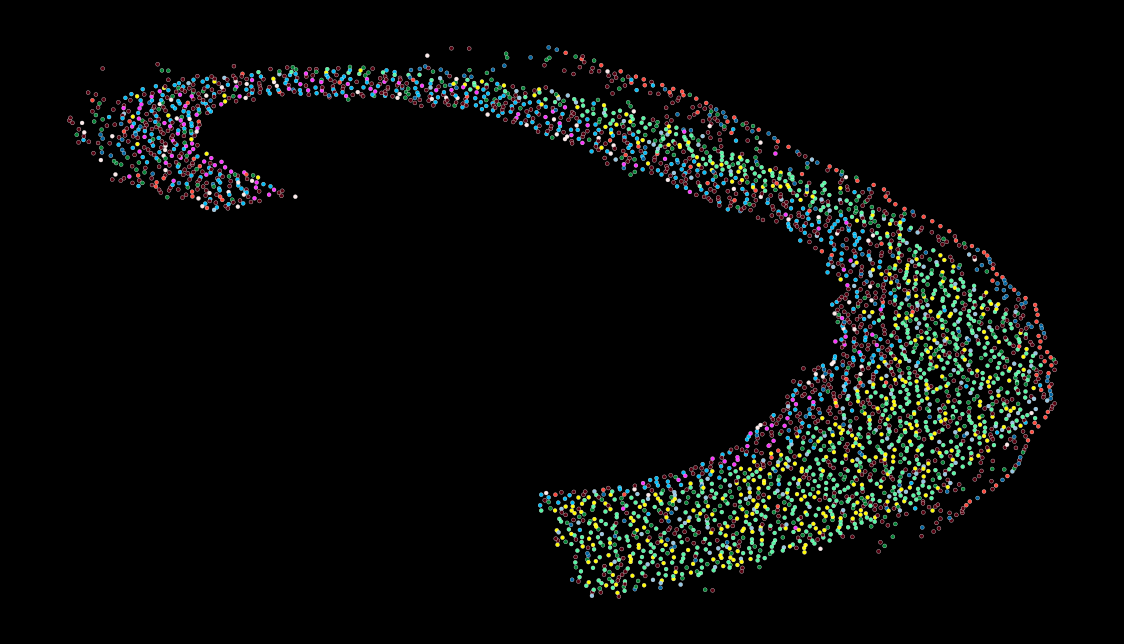

In [101]:
#Plotting the results of the ensemble model without noise from one of the clusters

plt.figure(figsize = (7,4), dpi = 200)

plt.style.use('dark_background')
plt.axis('off')

BGI_palette = sns.color_palette([ '#FFFB00', '#FF463B', '#53F7A3', '#560010', '#028334', '#92C6E4', '#0165A2', '#FDE9E9', '#FC32FF', '#00BBF6'])

#BGI_color_mapping = {4:'#53F7A3', 9:'#00BBF6', 8:'#0165A2', 7:'#FFFB00', 3:'#FDE9E9', 2:'#FF463B', 6:'#92C6E4', 1:'#FC32FF', 5:'#028334', 10:'#560010'}

sns.scatterplot(restructured_df[restructured_df['label'] != restructured_df.loc[175898]['label']]['x'], restructured_df[restructured_df['label'] != restructured_df.loc[175898]['label']]['y'], hue = restructured_df[restructured_df['label']!=restructured_df.loc[175898]['label']]['label'], s = 2, palette=BGI_palette)
plt.legend([], [], frameon = False);
